Predict incomes from the census data set

## Setup libraries

In [1]:
from pathlib import Path
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

import xgboost as xgb

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

## Get data

The file uci_data_set.py is used to retrieve the data

In [3]:
data_root = Path.home() / 'uci_data' / 'adult'
train_data = data_root / 'adult.data'
test_data = data_root / 'adult.test'

assert train_data.exists() and test_data.exists(
), "Use the python script to retrieve the data"

Create a list of column names and types

In [4]:
inputs = OrderedDict(
    (("age",
      ("continuous", )), ("workclass",
                          ("Private", "Self-emp-not-inc", "Self-emp-inc",
                           "Federal-gov", "Local-gov", "?", "State-gov",
                           "Without-pay", "Never-worked")), ("fnlwgt",
                                                             ("continuous", )),
     ("education",
      ("Bachelors", "Some-college", "11th", "HS-grad", "Prof-school",
       "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters",
       "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool")),
     ("education-num",
      ("continuous", )), ("marital-status",
                          ("Married-civ-spouse", "Divorced", "Never-married",
                           "Separated", "Widowed", "Married-spouse-absent",
                           "Married-AF-spouse")),
     ("occupation",
      ("Tech-support", "Craft-repair", "Other-service", "Sales",
       "Exec-managerial", "Prof-specialty", "Handlers-cleaners",
       "Machine-op-inspct", "Adm-clerical", "Farming-fishing",
       "Transport-moving", "Priv-house-serv", "Protective-serv",
       "Armed-Forces")), ("relationship",
                          ("Wife", "Own-child", "Husband", "Not-in-family",
                           "Other-relative", "Unmarried")),
     ("race", ("White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other",
               "Black")), ("sex", ("Female", "Male")), ("capital-gain",
                                                        ("continuous", )),
     ("capital-loss", ("continuous", )), ("hours-per-week", ("continuous", )),
     ("native-country",
      ("United-States", "Cambodia", "England", "Puerto-Rico", "Canada",
       "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece",
       "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy",
       "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland",
       "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti",
       "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand",
       "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong",
       "Holand-Netherlands")), ("income", ("<=50k", ">50k"))))

Create data frames

In [6]:
train_df = pd.read_csv(train_data, names=list(inputs.keys()), header=None)
test_df = pd.read_csv(test_data, names=list(inputs.keys()), header=None, skiprows=1)

Drop rows with unknown values marked with ?

In [7]:
train_df = train_df.replace(' ?', np.nan).dropna()
test_df = test_df.replace(' ?', np.nan).dropna()

Get sizes of training and test data sets

In [8]:
train_len = train_df.shape[0]
test_len = test_df.shape[0]
train_len, test_len

(30162, 15060)

Combine train and test datasets

In [9]:
combined_df = pd.concat([train_df, test_df])

Fix different strings for income in train and test data

In [10]:
combined_df['income'] = combined_df.income.apply(
    lambda x: x.strip()).replace(
    to_replace={'<=50K.': '<=50K', '>50K.': '>50K'})

## Get categorical and numeric columns

Get the types of columns

In [11]:
kinds = pd.Series(dt.kind for dt in combined_df.dtypes)
is_num = kinds != 'O'
num_cols = combined_df.columns[is_num]
cat_cols = combined_df.columns[~is_num]

Convert categorical features to numeric values

In [12]:
# for feature in cat_cols:
#     cat_col = combined_df[feature].astype('category')
#     combined_df[feature] = cat_col.cat.codes

## Clean data using pandas

Split data into features and labels, training and test set

In [13]:
feature_df = combined_df.drop(labels='income', axis=1)
label_df = combined_df[['income']].copy(deep=True)

cat_cols = cat_cols.drop('income')

feature_train = feature_df[:train_len]
label_train = label_df[:train_len]

feature_test = feature_df[train_len:]
label_test = label_df[train_len:]

## Clean data using sklearn pipeline

Create a pipeline for categorical

In [14]:
ohe = OneHotEncoder()
cat_pipe = Pipeline(steps=[
    ('ohe', ohe)
])

Create a pipeline to transform numeric values

In [15]:
num_pipe = Pipeline(steps=[
    ('ss', StandardScaler())
])

Create a column transformer to encode columns

In [16]:
ct = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

Apply column transformation to the training and test data

In [17]:
X_train = ct.fit_transform(feature_train).todense()
X_test = ct.transform(feature_test).todense()

Compare old and new feature dimensions

In [18]:
feature_train.shape, X_train.shape

((30162, 14), (30162, 104))

Get categorical mappings

In [19]:
# oe = ct.named_transformers_['cat'].named_steps['oe']
# cat_maps = dict(zip(cat_cols, oe.categories_))

In [21]:
ohe = ct.named_transformers_['cat'].named_steps['ohe']
cat_cols_codes = ['x{}'.format(idx) for idx in range(len(ohe.categories_))]
cat_maps = dict(zip(cat_cols, cat_cols_codes))
cat_cols_enc = ohe.get_feature_names()

Get the names of all the columns

In [22]:
all_cols = list(num_cols) + list(cat_cols_enc)

## Setup training and test data

In [23]:
y_train = label_train.income == '<=50K'
y_test = label_test.income == '<=50K'

## Dummy classifier

In [24]:
clf = DummyClassifier()
clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

/home/gavin/.local/share/virtualenvs/scikit-vm-8S7AlGJB/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.5036331842405786

## Naive Bayes classifier

In [25]:
clf = GaussianNB()
clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.6895405881233345

## Logistic regression classifier

In [26]:
clf = LogisticRegression(solver='lbfgs', n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.7654513228016749

## Gradient boosting classifier

In [27]:
gbr = GradientBoostingClassifier()
gbr.fit(X_train, y_train)
y_predict = gbr.predict(X_test)
roc_auc_score(y_test, y_predict)

0.7812911591168633

## XGBoost classifier

Use the scikit-learn interface

In [28]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train, y_train)
y_predict = xg_clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.7998967453368862

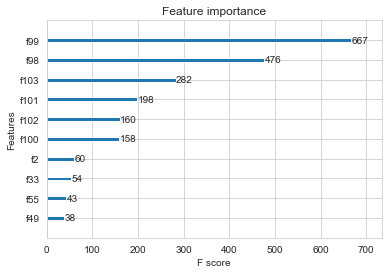

In [29]:
xgb.plot_importance(xg_clf, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 7]
plt.show()

Run gradient boosting classifier with cross validation

In [30]:
params = {
    'eta': 0.1,
    'seed': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'max_depth': 3,
    'min_child_weight': 1
}

dtrain = xgb.DMatrix(X_train, label=y_train)
cv_xgb = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=600,
    nfold=5,
    metrics=['auc'],
    early_stopping_rounds=50)  # Look for early stopping t

Show the last few results

In [31]:
cv_xgb.tail(5)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
485,0.942410,0.000649,0.926973,0.002157
486,0.942429,0.000650,0.926958,0.002181
487,0.942466,0.000635,0.926980,0.002203
488,0.942489,0.000631,0.926992,0.002173
489,0.942531,0.000638,0.926993,0.002166


Text(0.5, 0, 'number of rounds')

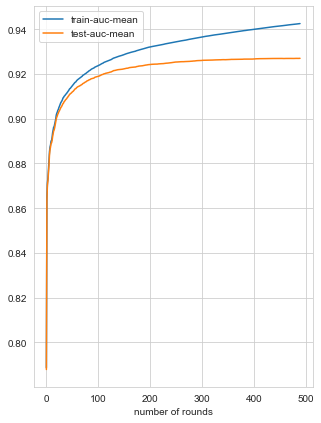

In [32]:
ax = cv_xgb.plot(y=['train-auc-mean', 'test-auc-mean'])
ax.set_xlabel('number of rounds')

Use the non-sklearn interface to specify the num_boost_rounds

In [33]:
evals_result = {}
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=500,
                evals_result=evals_result)

Use the best predictor to calculate auc

In [34]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_predict = bst.predict(dtest)
roc_auc_score(y_test, y_predict)

0.9267011562618956